# Viola Jones

This week, we are going to work the Viola Jones face detection algorithm. 
To illustrate its behaviour, we are going to use two datasets, each one with its own properties.

Next link contains a detailed explaination about how the OpenCV Viola Jones implementation works:
- https://www.pyimagesearch.com/2021/04/12/opencv-haar-cascades/


In [96]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams['figure.figsize'] = [20, 10]

## Datasets

In this section we are going to introduce both datasets we are going to use.
One dataset contains only face images and the other one contains people on a real environment.

### The Labeled Faces in the Wild face recognition dataset

This dataset is composed by images which only contains people faces. It could be very useful to train an image classifier, but our aim simply is to observe the how Viola Jones algorithm work in a simple environment.

You will find more information about the dataset at the next url: https://scikit-learn.org/0.16/datasets/labeled_faces.html

This dataset belongs to sklearn (scikit-learn) library, so, first step will be to install that library. To do that you can uncomment next cell and execute it (Assuming you are using conda as environment manager).

In [ ]:
# !conda install --yes --prefix {sys.prefix} scikit-learn

Once the library is installed, we can access the dataset data.

Next, to check if we can use the dataset, let's download it and query some information:

In [97]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

for name in lfw_people.target_names:
    print(name)

Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Tony Blair


We are also interested on images information:

In [98]:
lfw_people.images.shape

(1288, 50, 37)

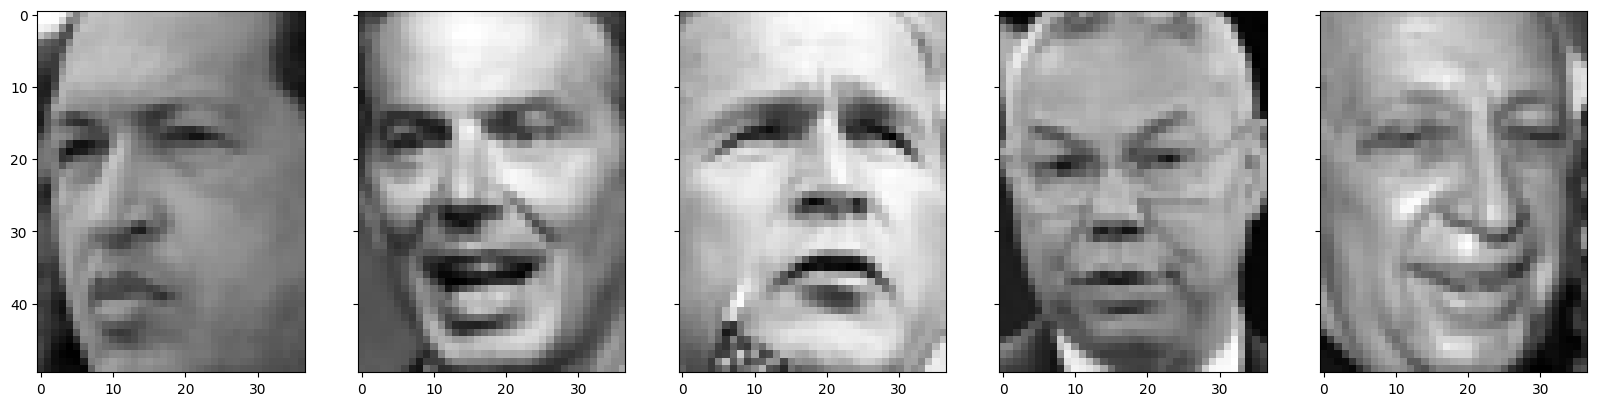

In [99]:
n_images = 5
fig, axs = plt.subplots(1, n_images, sharey='row')
for i in range(n_images):
    axs[i].imshow((lfw_people.images[i]*255).astype(np.uint8), cmap="gray")

### WIDE dataset

Dataset description provided by the author:
```
WIDER FACE dataset is a face detection benchmark dataset, of which images are selected from the publicly available WIDER dataset. We choose 32,203 images and label 393,703 faces with a high degree of variability in scale, pose and occlusion as depicted in the sample images. WIDER FACE dataset is organized based on 61 event classes. For each event class, we randomly select 40%/10%/50% data as training, validation and testing sets. We adopt the same evaluation metric employed in the PASCAL VOC dataset. Similar to MALF and Caltech datasets, we do not release bounding box ground truth for the test images. Users are required to submit final prediction files, which we shall proceed to evaluate.
```
Dataset url: http://shuoyang1213.me/WIDERFACE/

Summarizng previous information, that dataset is composed by 32203 images labelled with the bounding box of the faces on it. Also, the images are split in 61 classes according to the event type where its are took.

In this exercise we will only use the training set images, ignoring the validation and test sets.

Once we have downloaded the **images and annotations** from the training set, let's see how to load the dataset data.
First, we have to load the object which allows us to obtain the bounding boxes for each training set image. This image is inside the file "wider_face_train.mat", downloaded with the dataset annotations.
This file contains a Matlab object, fortunately, scipy library allow us to load that kind of objects from that other language with the next function:

> **NOTE:** You should ajust the path of the file with the dataset location inside your computer.

In [80]:
import scipy.io as sio
labels = sio.loadmat('wider_face_split/wider_face_train.mat')

Let's see the properties of this object:

In [81]:
labels.keys()

dict_keys(['__header__', '__version__', '__globals__', 'blur_label_list', 'event_list', 'expression_label_list', 'face_bbx_list', 'file_list', 'illumination_label_list', 'invalid_label_list', 'occlusion_label_list', 'pose_label_list'])

From the loaded object keys we are interested with the following ones:
* **file_list:** Names of the image files.
* **face_bbx_list:** Labels of each image bounding boxes.
* **event_list:** Position of each event images inside the structure.


Let's get the position of the images of each event inside the structure:

In [82]:
labels['event_list']

array([[array(['0--Parade'], dtype='<U9')],
       [array(['1--Handshaking'], dtype='<U14')],
       [array(['10--People_Marching'], dtype='<U19')],
       [array(['11--Meeting'], dtype='<U11')],
       [array(['12--Group'], dtype='<U9')],
       [array(['13--Interview'], dtype='<U13')],
       [array(['14--Traffic'], dtype='<U11')],
       [array(['15--Stock_Market'], dtype='<U16')],
       [array(['16--Award_Ceremony'], dtype='<U18')],
       [array(['17--Ceremony'], dtype='<U12')],
       [array(['18--Concerts'], dtype='<U12')],
       [array(['19--Couple'], dtype='<U10')],
       [array(['2--Demonstration'], dtype='<U16')],
       [array(['20--Family_Group'], dtype='<U16')],
       [array(['21--Festival'], dtype='<U12')],
       [array(['22--Picnic'], dtype='<U10')],
       [array(['23--Shoppers'], dtype='<U12')],
       [array(['24--Soldier_Firing'], dtype='<U18')],
       [array(['25--Soldier_Patrol'], dtype='<U18')],
       [array(['26--Soldier_Drilling'], dtype='<U20')],
      

To ease future work, let's format the list as follows:

In [83]:
event_list = [labels['event_list'][i][0][0] for i in range(len(labels['event_list']))]
event_list

['0--Parade',
 '1--Handshaking',
 '10--People_Marching',
 '11--Meeting',
 '12--Group',
 '13--Interview',
 '14--Traffic',
 '15--Stock_Market',
 '16--Award_Ceremony',
 '17--Ceremony',
 '18--Concerts',
 '19--Couple',
 '2--Demonstration',
 '20--Family_Group',
 '21--Festival',
 '22--Picnic',
 '23--Shoppers',
 '24--Soldier_Firing',
 '25--Soldier_Patrol',
 '26--Soldier_Drilling',
 '27--Spa',
 '28--Sports_Fan',
 '29--Students_Schoolkids',
 '3--Riot',
 '30--Surgeons',
 '31--Waiter_Waitress',
 '32--Worker_Laborer',
 '33--Running',
 '34--Baseball',
 '35--Basketball',
 '36--Football',
 '37--Soccer',
 '38--Tennis',
 '39--Ice_Skating',
 '4--Dancing',
 '40--Gymnastics',
 '41--Swimming',
 '42--Car_Racing',
 '43--Row_Boat',
 '44--Aerobics',
 '45--Balloonist',
 '46--Jockey',
 '47--Matador_Bullfighter',
 '48--Parachutist_Paratrooper',
 '49--Greeting',
 '5--Car_Accident',
 '50--Celebration_Or_Party',
 '51--Dresses',
 '52--Photographers',
 '53--Raid',
 '54--Rescue',
 '55--Sports_Coach_Trainer',
 '56--Voter

In [84]:
print("file_list shape:", labels['file_list'].shape)
print("face_bbx_list shape:", labels['face_bbx_list'].shape)

file_list shape: (61, 1)
face_bbx_list shape: (61, 1)


We can see that each element contains a vector with a single element for each event group (Remember the 61 kind of images of the dataset split).

At the moment, we are going to work with a single class, so we can do the following.
We can select all the image of the event 0--Parade, which we know (from event_list) that it is in the position 0 of the vector.

In [126]:
file_list = labels['file_list'][21]
face_bbx_list = labels['face_bbx_list'][21]
print("file_list shape:", file_list.shape)
print("face_bbx_list shape:", face_bbx_list.shape)

file_list shape: (1,)
face_bbx_list shape: (1,)


In [132]:
file_list = labels['file_list'][21][0]
face_bbx_list = labels['face_bbx_list'][21][0]
print("file_list shape:", file_list.shape)
print("face_bbx_list shape:", face_bbx_list.shape)

file_list shape: (184, 1)
face_bbx_list shape: (184, 1)


Now, we have the name of all images in the folder "0--Parade" (We know that by the 0 index which indicate the name of the folder) inside the variable file_list. And the list of all the bounding boxes in each image inside the variable face_bbx_list.

If we inspect an element we are going to see that it still don't have a desired format, so we will have to format the images list in such a way that each cell contains the name of each image without varying its position in the list.

In [133]:
file_list[0]

array([array(['28_Sports_Fan_Sports_Fan_28_288'], dtype='<U31')],
      dtype=object)

In [127]:
images_names = [file_list[i][21][0] for i in range(len(file_list))]
len(file_list)

1

In [128]:
images_names[:5]

[array(['28_Sports_Fan_Sports_Fan_28_916'], dtype='<U31')]

The bounding box list has the same format problem than the images name list, so we are going to format it too:

In [90]:
face_bbx_list[0]

array([array([[449, 330, 122, 149]])], dtype=object)

In [91]:
face_bbx_list = [face_bbx_list[i][0] for i in range(len(face_bbx_list))]
len(face_bbx_list)

460

In [92]:
face_bbx_list[:3]

[array([[449, 330, 122, 149]]),
 array([[361,  98, 263, 339]]),
 array([[ 78, 221,   7,   8],
        [ 78, 238,  14,  17],
        [113, 212,  11,  15],
        [134, 260,  15,  15],
        [163, 250,  14,  17],
        [201, 218,  10,  12],
        [182, 266,  15,  17],
        [245, 279,  18,  15],
        [304, 265,  16,  17],
        [328, 295,  16,  20],
        [389, 281,  17,  19],
        [406, 293,  21,  21],
        [436, 290,  22,  17],
        [522, 328,  21,  18],
        [643, 320,  23,  22],
        [653, 224,  17,  25],
        [793, 337,  23,  30],
        [535, 311,  16,  17],
        [ 29, 220,  11,  15],
        [  3, 232,  11,  15],
        [ 20, 215,  12,  16]])]

Finally, let's visualize a dataset image:

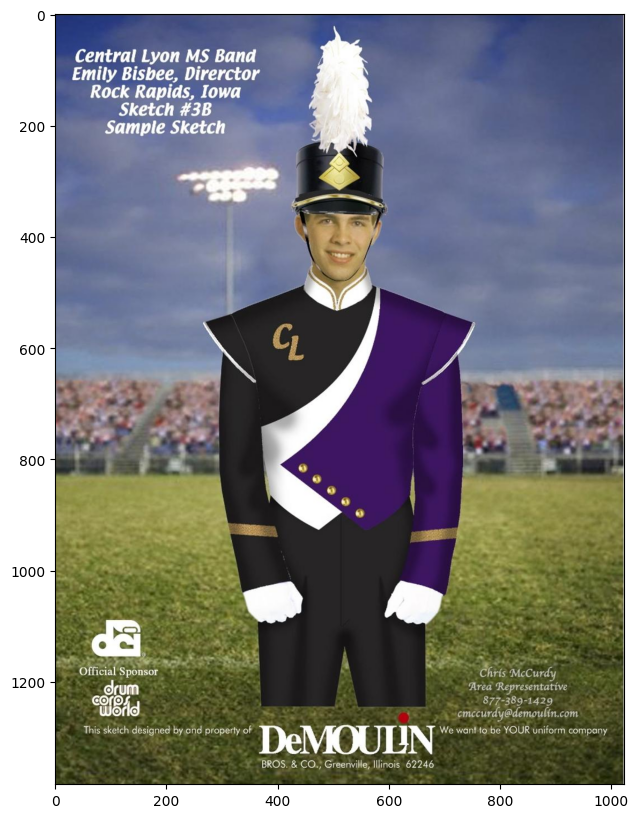

In [100]:
im = cv2.imread('WIDER_train/images/0--Parade/' + images_names[0] + '.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

And, if we draw its bounding boxes:

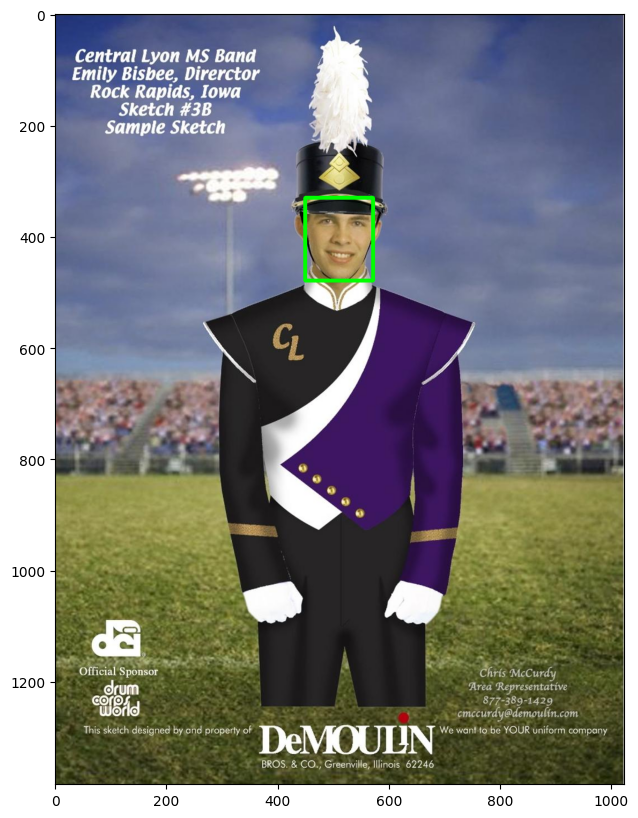

In [101]:
im_bb = im.copy()
for x1, y1, w, h in face_bbx_list[0]:
    cv2.rectangle(im_bb, (x1, y1), (x1+w, y1+h), (0, 255, 0), 5)
plt.imshow(im_bb);

To have a more general vision let's draw a set of images from the set and its BB.

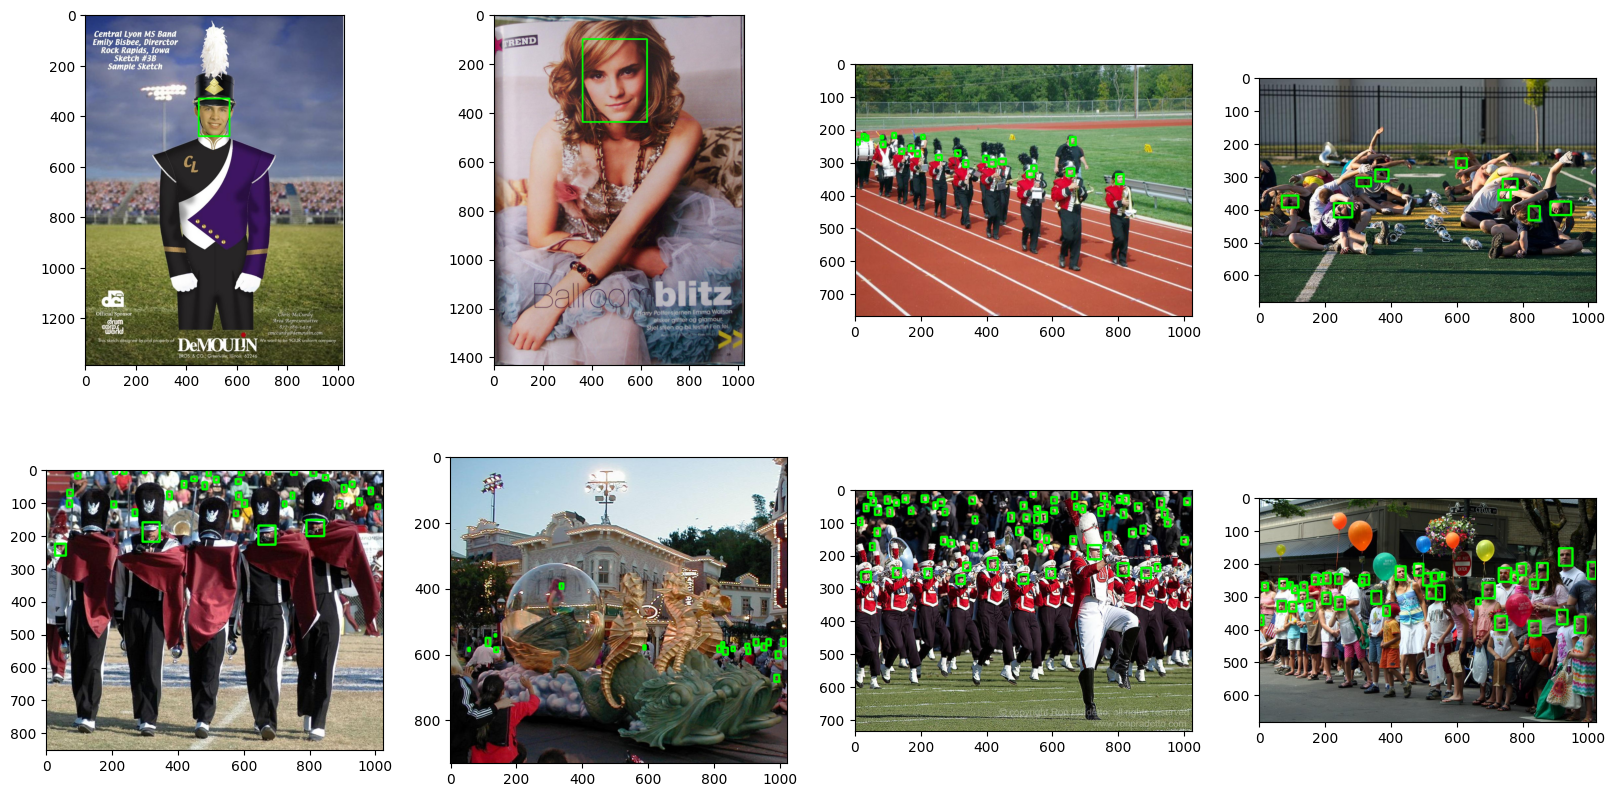

In [103]:
fig, axs = plt.subplots(2, 4)
axs = axs.flatten()
for i in range(len(axs)):
    image_name = images_names[i]
    image_bbs = face_bbx_list[i]
    im = cv2.imread('WIDER_train/images/0--Parade/' + image_name + '.jpg')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for x1, y1, w, h in image_bbs:
        cv2.rectangle(im, (x1, y1), (x1+w, y1+h), (0, 255, 0), 5)
    axs[i].imshow(im, cmap="gray")

## Algorithm

https://docs.opencv.org/4.5.2/d1/de5/classcv_1_1CascadeClassifier.html#aaf8181cb63968136476ec4204ffca498

**Algorithm parameter:** File with the pretrained Haar Cascade parameters.

In [104]:
faceCascade = cv2.CascadeClassifier("haarcascades/haarcascade_frontalface_default.xml")

Observe the efect of the scaleFactor and minNeighbors parameters.

* minNeighbors (default: 3): Parameter specifying how many neighbors each candidate rectangle should have to retain it.

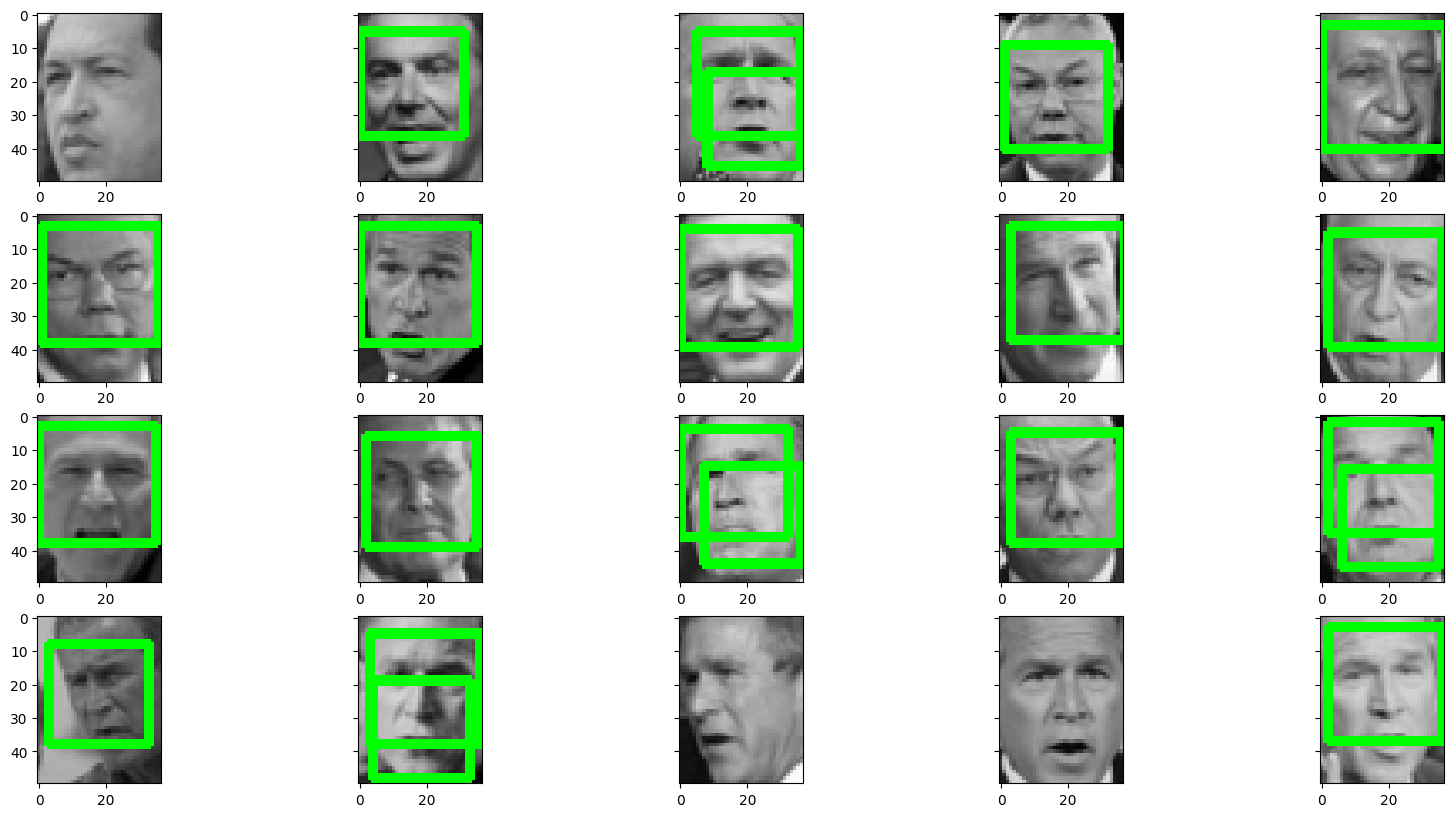

In [105]:
fig, axs = plt.subplots(4, 5, sharey='row')
axs = axs.flatten()
for i in range(len(axs)):
    image_gray = (lfw_people.images[i]*255).astype(np.uint8)
    rectangles = faceCascade.detectMultiScale(image_gray, scaleFactor=1.001, minNeighbors=5)
    image_rgb = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
    for x1, y1, w, h in rectangles:
        cv2.rectangle(image_rgb, (x1, y1), (x1+w, y1+h), (0, 255, 0), 2)
    axs[i].imshow(image_rgb, cmap="gray")

### WIDE dataset

In [106]:
faceCascade = cv2.CascadeClassifier("haarcascades/haarcascade_frontalface_alt.xml")

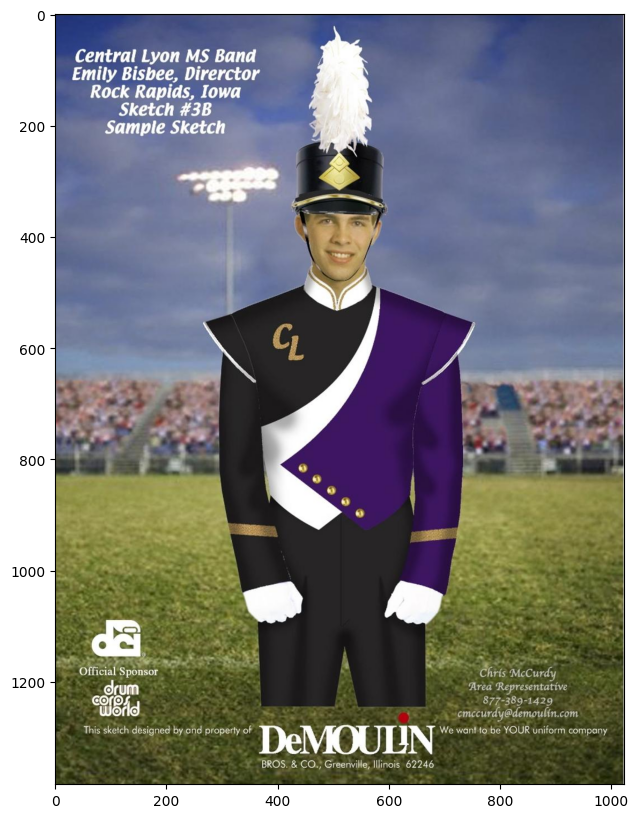

In [107]:
im = cv2.imread('WIDER_train/images/0--Parade/' + images_names[0] + '.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [108]:
im_resized = cv2.resize(im, dsize=None, fx=0.5, fy=0.5)
image_gray = cv2.cvtColor(im_resized, cv2.COLOR_BGR2GRAY)
rectangles = faceCascade.detectMultiScale(image_gray, scaleFactor=1.01, minNeighbors=5, minSize=(50, 50))
rectangles

array([[224, 162,  68,  68]])

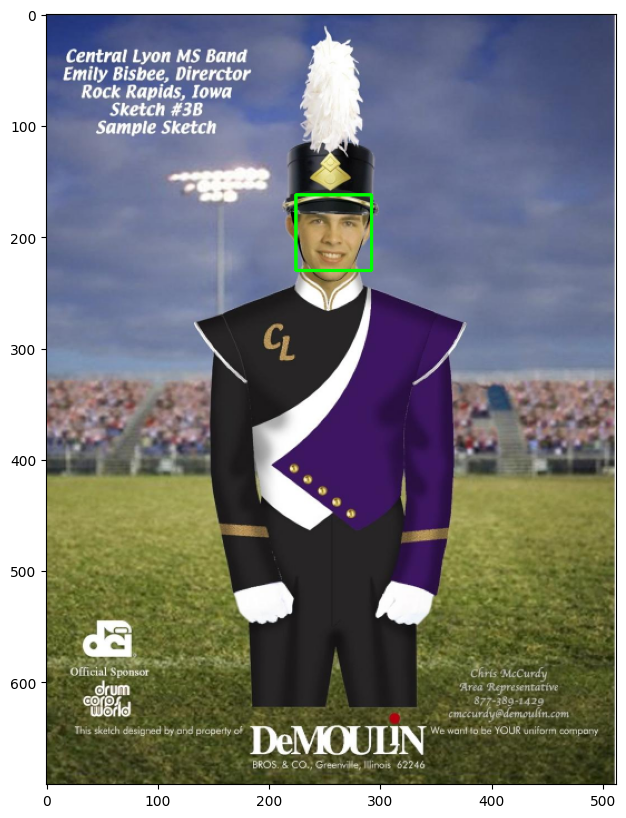

In [109]:
for x1, y1, x2, y2 in rectangles:
    cv2.rectangle(im_resized, (x1, y1), (x1+x2, y1+y2), (0, 255, 0), 2)
plt.imshow(im_resized);

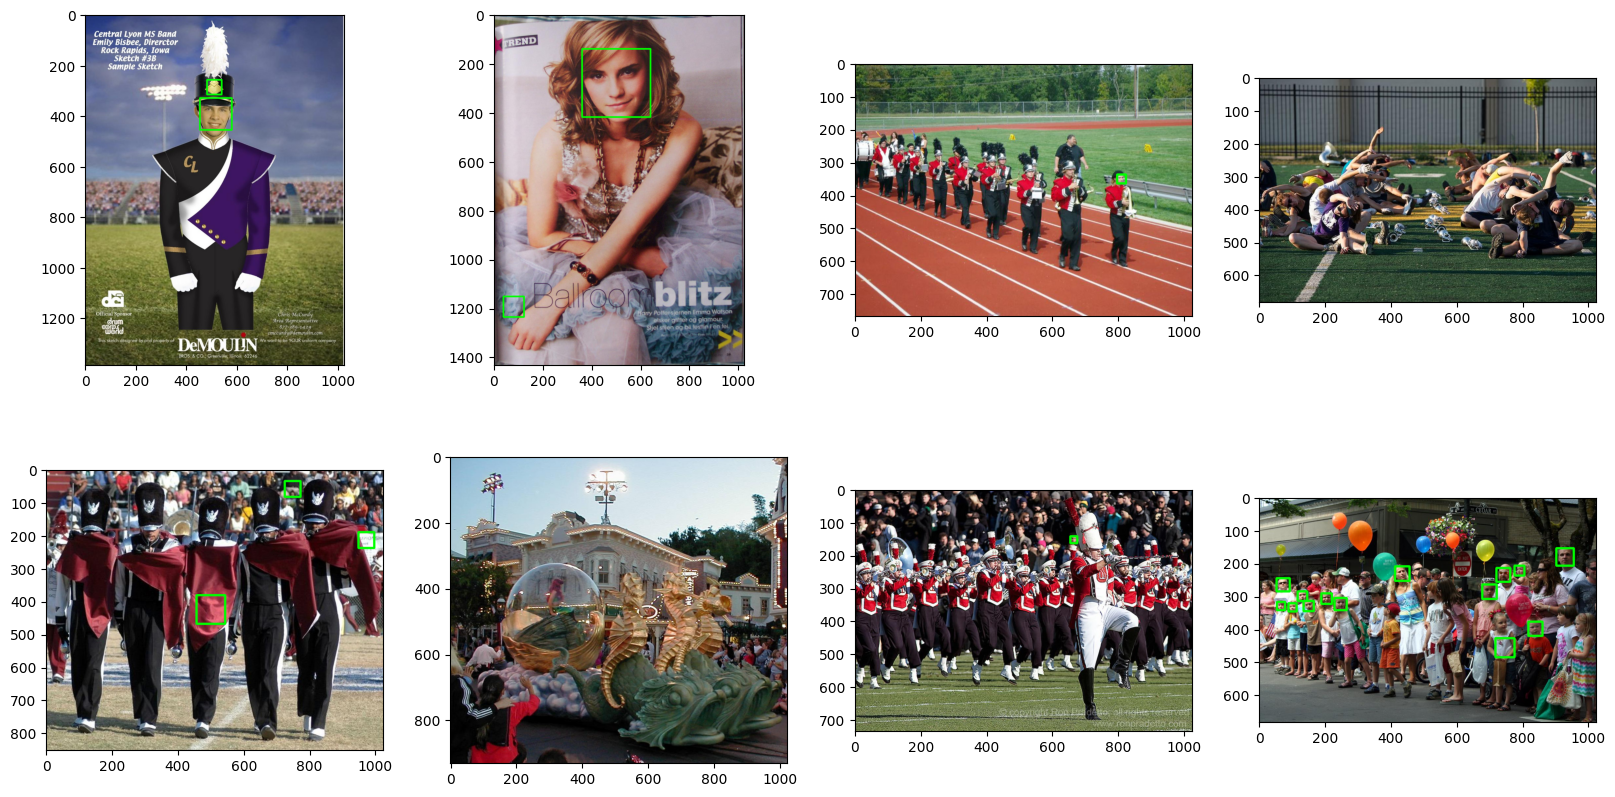

In [110]:
plt.rcParams['figure.figsize'] = [20, 10]
n_images = 5
fig, axs = plt.subplots(2, 4)
axs = axs.flatten()
for i in range(len(axs)):
    image_name = images_names[i]
    im = cv2.imread('WIDER_train/images/0--Parade/' + image_name + '.jpg')
    im_color = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    rectangles = faceCascade.detectMultiScale(image_gray)
    for x1, y1, x2, y2 in rectangles:
         cv2.rectangle(im_color, (x1, y1), (x1+x2, y1+y2), (0, 255, 0), 5)
    axs[i].imshow(im_color, cmap="gray")

> Interesting read: https://levelup.gitconnected.com/unleashing-the-power-of-viola-jones-method-96ad41a5ceb4

## Tasks

Evaluate the 100 first images from the scene 21--Festival.

* Extract IOU evaluation metric.
* Identify erroneous detections (Images with IOU < 0.45).
* Describe the reason why the face detection has failed in the images identified in the previous question.
* Identify which cases we could tune the algorithm to detect the face and in which is impossible because of the algotithm nature.

**HINT:** https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ 


To assign an IoU value at each image we will use the next function.
The function, for each face in an image, compute the IoU of the nearest detected face. Finally, it returns the mean IoU from all image faces.

Observe that this evaluation metric has a set of problems. The most important one is that false negatives (faces detected where there aren't any face) don't penalize its value.
But, as we want to analyse cases when faces aren't detected, this computation is appropiate.

In [302]:
from IPython.display import display, Image
import metrics
import cv2
import scipy.io as sio
import numpy as np
import os

In [317]:
# Load the dataset data
labels = sio.loadmat('wider_face_split/wider_face_train.mat')
labels['event_list']

# List format
event_list = [labels['event_list'][i][0][0] for i in range(len(labels['event_list']))]
print(event_list)

# Finding the index for the "21--Festival" event
festival_index = event_list.index('21--Festival')
print(festival_index)

['0--Parade', '1--Handshaking', '10--People_Marching', '11--Meeting', '12--Group', '13--Interview', '14--Traffic', '15--Stock_Market', '16--Award_Ceremony', '17--Ceremony', '18--Concerts', '19--Couple', '2--Demonstration', '20--Family_Group', '21--Festival', '22--Picnic', '23--Shoppers', '24--Soldier_Firing', '25--Soldier_Patrol', '26--Soldier_Drilling', '27--Spa', '28--Sports_Fan', '29--Students_Schoolkids', '3--Riot', '30--Surgeons', '31--Waiter_Waitress', '32--Worker_Laborer', '33--Running', '34--Baseball', '35--Basketball', '36--Football', '37--Soccer', '38--Tennis', '39--Ice_Skating', '4--Dancing', '40--Gymnastics', '41--Swimming', '42--Car_Racing', '43--Row_Boat', '44--Aerobics', '45--Balloonist', '46--Jockey', '47--Matador_Bullfighter', '48--Parachutist_Paratrooper', '49--Greeting', '5--Car_Accident', '50--Celebration_Or_Party', '51--Dresses', '52--Photographers', '53--Raid', '54--Rescue', '55--Sports_Coach_Trainer', '56--Voter', '57--Angler', '58--Hockey', '59--people--driving-

In [304]:
file_list = labels['file_list'][festival_index][0]
face_bbx_list = labels['face_bbx_list'][festival_index][0]


print("file_list shape:", file_list.shape)
print("face_bbx_list shape:", face_bbx_list.shape)

file_list shape: (180, 1)
face_bbx_list shape: (180, 1)


In [305]:
# Initialize face detector
faceCascade = cv2.CascadeClassifier("haarcascades/haarcascade_frontalface_default.xml")

# Function to evaluate the image using IoU metric
def evaluate_image(real_bbs, detected_bbs):
    real_bb_iou = []
    for real_bb in real_bbs:
        ious = [0.]
        for detected_bb in detected_bbs:
            iou = metrics.IoU_bounding_box(real_bb, detected_bb)
            ious.append(iou)
        real_bb_iou.append(max(ious))
    return np.mean(real_bb_iou)


In [309]:
iou_values = []
erroneous_detections = []

image_names = [file_list[i][0][0] for i in range(len(file_list))]
print(image_names)

print("Erroneous detections where IOU less of 0.45 and its IoU values for each image:")
for i in range(100):
    image_path = f"WIDER_train/images/21--Festival/{image_names[i]}.jpg" # Path of the image
    
    # Read image and convert it
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    detected = faceCascade.detectMultiScale(image_gray, scaleFactor=1.1, minNeighbors=5, minSize=(50,50))
    
    # If faces are detected, convert the bounding boxes to a list
    detected = detected.tolist() if isinstance(detected, np.ndarray) else []
    detected_bbs = [(x,y,w,h) for (x,y,w,h) in detected]

    # Paint Bounding Boxes process
    for(x1, y1, w, h) in detected_bbs: # Detected bb as RED
        cv2.rectangle(image, (x1, y1), (x1+w, y1+h), (255,0,0), 5)

    real_bbs = face_bbx_list[i][0] # Real bb as BLUE
    for(x2, y2, w, h) in real_bbs:
        cv2.rectangle(image, (x2, y2), (x2+w, y2+h), (0, 0, 255), 2)
        
    # Calculate mean_iou only if there are real bounding boxes
    mean_iou = evaluate_image(real_bbs, detected_bbs)
    iou_values.append(mean_iou)
    
    # Check for erroneous detections
    if mean_iou < 0.45:
        
        if not os.path.exists("Erroneous_detections"):
            os.makedirs("Erroneous_detections")
        cv2.imwrite(f"Erroneous_detections/{image_names[i]}.jpg", image) # Save the painted image with both bb
        
        erroneous_detections.append(image_names[i])
        print(f"{image_names[i]}: IoU = {mean_iou}")

['21_Festival_Festival_21_14', '21_Festival_Festival_21_303', '21_Festival_Festival_21_663', '21_Festival_Festival_21_353', '21_Festival_Festival_21_789', '21_Festival_Festival_21_253', '21_Festival_Festival_21_305', '21_Festival_Festival_21_702', '21_Festival_Festival_21_489', '21_Festival_Festival_21_65', '21_Festival_Festival_21_307', '21_Festival_Festival_21_826', '21_Festival_Festival_21_680', '21_Festival_Festival_21_697', '21_Festival_Festival_21_836', '21_Festival_Festival_21_412', '21_Festival_Festival_21_293', '21_Festival_Festival_21_974', '21_Festival_Festival_21_41', '21_Festival_Festival_21_981', '21_Festival_Festival_21_767', '21_Festival_Festival_21_824', '21_Festival_Festival_21_91', '21_Festival_Festival_21_624', '21_Festival_Festival_21_531', '21_Festival_Festival_21_85', '21_Festival_Festival_21_119', '21_Festival_Festival_21_627', '21_Festival_Festival_21_71', '21_Festival_Festival_21_484', '21_Festival_Festival_21_610', '21_Festival_Festival_21_869', '21_Festival_

------------------------------------------

There are 82 images with erroneous detections with a mean IoU of 0.1679283677670682

------------------------------------------
Demostration example of image with erroneous detection
- Detection bounding boxes -> BLUE colour
- Real bounding boxes -> RED colour


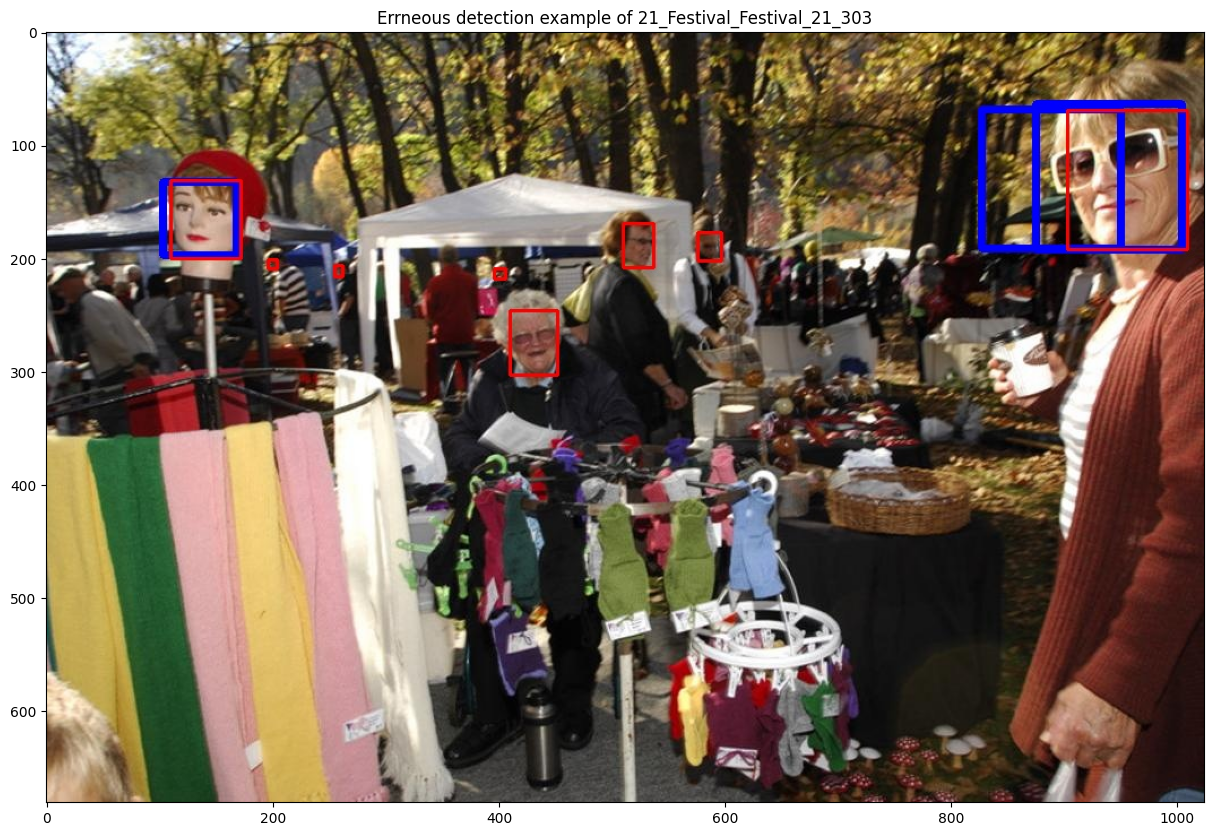

In [316]:
print("------------------------------------------")
print(f"\nThere are {len(erroneous_detections)} images with erroneous detections with a mean IoU of {np.mean(iou_values)}\n")
print("------------------------------------------")
print("Demostration example of image with erroneous detection")
print("- Detection bounding boxes -> BLUE colour")
print("- Real bounding boxes -> RED colour")

path_aux = f'Erroneous_detections/{image_names[9]}.jpg'
img = cv2.imread(path_aux)

if img is None:
    print(f"NNo carga de {path_aux}")
else:
    # Convertir de BGR a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Mostrar la imagen
    plt.imshow(img)
    plt.title(f'Errneous detection example of {image_names[1]}')
    plt.show()


# Reasons for Face Detection Failure:

In analyzing the provided images from festival scenes, it becomes clear that certain factors recurrently contribute to the failure of face detection. These factors, intrinsic to the operational limitations of the algorithm and environmental variables, often overlap and interplay to complicate the detection process.

* Occlusion: Faces that are partially hidden by other objects or individuals in the crowd are not accurately detected as the algorithm relies on seeing complete facial features for successful identification.
* Angle and Position: Faces not directed straight towards the camera are often missed because the Haar classifier is primarily trained on frontal facial images.
* Lighting Conditions: Adverse lighting can distort facial features, rendering them unrecognizable to the algorithm.
* Scale Variations: Smaller faces or those at varying distances from the camera might not be detected if they fall below the minimum detection size or are outside the scales the classifier is optimized for.
* High Person Density: In images with a high density of people, such as at festivals or concerts, the multitude of faces can lead to overlapping detections or missed individual faces.

# Identifying tunable Cases and algorithm Limitations:

While algorithmic parameters offer some degree of flexibility, there are inherent limitations within the Haar classifier that restrict its adaptability. By dissecting both the tunable aspects and the limitations, we can delineate the potential for improvement versus the fundamental redesign that may be required.

### Tunable Cases:

* Detection Size: Adjusting the minimum face size for detection could help capture smaller faces but might also increase false positives.
Neighbors Count: Increasing the number of neighbors can reduce false positives in densely populated images.
* Detection Thresholds: Modifying the detection thresholds might allow for the identification of faces with less distinct features, though this could also lead to more false positives.

### Algorithm limitations:

* Severe Occlusion: If a face is mostly obscured, it's unlikely any parameter adjustment will enable its correct detection.
* Extreme Angles: Faces at extreme angles or profiles cannot be reliably detected with the Haar classifier.
* Extreme Lighting Conditions: Very poor lighting or backlighting can change the appearance of faces beyond what the algorithm can compensate for.
* Feature-Based Algorithm: The Haar classifier relies on feature detection, making it inherently limited compared to more advanced approaches like Convolutional Neural Networks (CNNs).